<a href="https://colab.research.google.com/github/crisalex25/TFM_HydroMLGenerationOptimization/blob/main/TFM_Evaluaci%C3%B3n_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo de Fin de Master**
## **Máster Universitario en Inteligencia Artificial para el Sector de la Energía y las Infraestructuras**
Optimización de generación en centrales hidroeléctricas mediante técnicas de aprendizaje automático

#Librerías y Dataset

In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('fast')

In [ ]:
AC="https://raw.githubusercontent.com/crisalex25/TFM/main/AC3.csv"
GC="https://raw.githubusercontent.com/crisalex25/TFM/main/GC3.csv"

In [ ]:
dfAC = pd.read_csv(AC, sep=';', decimal=",", parse_dates=['Fecha_Hora'])
dfGC = pd.read_csv(GC, sep=';', decimal=",", parse_dates=['Fecha_Hora'])

fecha_limite = datetime(2023, 1, 1, 0, 0)  # Fecha límite

dfAC = dfAC[dfAC['Fecha_Hora'] <= fecha_limite]
dfGC = dfGC[dfGC['Fecha_Hora'] <= fecha_limite]

# Predicción demanda Autonconsumos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# Extraer la columna de demanda de energía
demand_data = dfAC['valor'].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
demand_data_normalized = scaler.fit_transform(demand_data.reshape(-1, 1))

# Dividir los datos en conjuntos de entrenamiento y prueba
validation_split = 0.2
train_size = int(len(demand_data_normalized) * (1 - validation_split))
train_data, test_data = demand_data_normalized[:train_size], demand_data_normalized[train_size:]

# Crear secuencias de entrada y salida para el entrenamiento de la red neuronal
sequence_length = 24
X_train, y_train = [], []
X_test, y_test = [], []
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data[i:i+sequence_length])
    y_train.append(train_data[i+sequence_length])
for i in range(len(test_data) - sequence_length):
    X_test.append(test_data[i:i+sequence_length])
    y_test.append(test_data[i+sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Crear el modelo de red neuronal
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='MSE', metrics=["mae","mse"])
model.summary()

# Entrenar el modelo
epochs = 20
batch_size = 16
patience = 3
early_stopping = EarlyStopping(patience=patience)  # Detener el entrenamiento si no hay mejora en el número de épocas especificado
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Desnormalizar los datos de predicción
y_pred_denormalized = scaler.inverse_transform(y_pred)
y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 32)            4352      
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1786/1786 [==============================] - 49s 26ms/step - loss: 0.0081 - mae: 0.0455 - mse: 0.0081 - val_loss: 0.0019 - val_mae: 0.0318 - val_mse: 0.0019
Epoch 2/20
1786/1786 [==============================] - 42s 24ms/step - loss: 0.0013 - mae: 0.0252 - mse: 0.0013 - val_loss: 0.0012 - val_mae: 0.023

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular el error absoluto medio (MAE) y el error cuadrático medio (MSE)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized)
r2 = r2_score(y_test_denormalized, y_pred_denormalized)

print('Error absoluto medio (MAE):', mae)
print('Error cuadrático medio (MSE):', mse)
print('Coeficiente de determinación (R^2):', r2)

Error absoluto medio (MAE): 85.00283477505614
Error cuadrático medio (MSE): 17490.84934033414
Coeficiente de determinación (R^2): 0.9138499735851683


In [ ]:
import pandas as pd
from datetime import datetime

# URL del archivo CSV
url = "https://raw.githubusercontent.com/crisalex25/TFM/main/AC3.csv"

# Leer el CSV y convertir la columna de fechas a datetime
df = pd.read_csv(url, sep=';', decimal=",", parse_dates=['Fecha_Hora'])

# Definir la fecha límite como el 11 de enero de 2023
fecha_limite = datetime(2023, 1, 12, 0, 0)

# Filtrar los datos para quedarse con los registros anteriores o iguales a la fecha límite
df_filtered = df[df['Fecha_Hora'] <= fecha_limite]

# Quedarse con los últimos 48 valores (si los datos están ordenados cronológicamente)
df_filtered_last_48 = df_filtered.tail(48)

# Mantener solamente los valores de la segunda columna (asumiendo que es la columna 1)
column_values = df_filtered_last_48.iloc[:, 1].to_numpy()

# Separar los valores en input_values (primeros 24) y real_values (últimos 24)
input_values = column_values[:24]
real_values = column_values[24:]

# Imprimir los valores de las columnas
print("Input Values:", input_values)
print("Real Values:", real_values)

Input Values: [4601.721 4500.178 4728.418 4677.025 4777.697 4836.232 4828.607 4901.386
 5029.889 5083.709 5151.891 5103.779 5054.847 5049.783 5128.552 5060.06
 5072.145 5076.629 5001.813 4834.589 4872.308 4868.052 4840.913 4869.426]
Real Values: [4799.201 4753.733 4776.88  4763.598 4774.316 4799.665 4811.773 4796.388
 5041.419 5109.742 5140.174 5239.75  5078.159 5133.345 5170.147 5246.571
 5403.234 5180.302 4930.985 4910.551 4920.423 5044.975 5000.643 5037.954]


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalizar los valores de entrada
scaler = MinMaxScaler(feature_range=(0, 1))
input_values_normalized = scaler.fit_transform(input_values.reshape(-1, 1))
real_values_normalized = scaler.fit_transform(real_values.reshape(-1, 1))

# valores de entrada
last_input_sequence = input_values_normalized

# Realizar predicciones para los próximos 24 valores
next_predictions = []
for i in range(24):
    # Preparar los últimos valores de entrada para la predicción
    next_input = last_input_sequence[-sequence_length:]  # Tomar el último valor real
    next_input = np.array(next_input).reshape(1, sequence_length, 1)

    # Realizar la predicción
    next_prediction = model.predict(next_input)

    # Agregar la predicción a la lista de predicciones
    next_predictions.append(next_prediction[0, 0])

    # Actualizar los últimos valores de entrada
    last_input_sequence = np.concatenate((last_input_sequence, real_values_normalized[i+1:i+2]), axis=0)

# Desnormalizar las predicciones
next_predictions_denormalized = scaler.inverse_transform(np.array(next_predictions).reshape(-1, 1))

print("Predicciones para los próximos 24 valores:")
print(next_predictions_denormalized)



1/1 [==============================] - 0s 24ms/step
Predicciones para los próximos 24 valores:
[[5132.5757]
 [4912.069 ]
 [4881.1714]
 [4849.643 ]
 [4835.879 ]
 [4834.156 ]
 [4831.614 ]
 [4819.792 ]
 [5031.831 ]
 [5112.47  ]
 [5143.697 ]
 [5260.858 ]
 [5068.874 ]
 [5160.773 ]
 [5184.5977]
 [5268.566 ]
 [5384.4326]
 [5173.121 ]
 [4999.8267]
 [4968.9326]
 [4957.266 ]
 [5061.5693]
 [5008.5205]
 [5045.9966]]


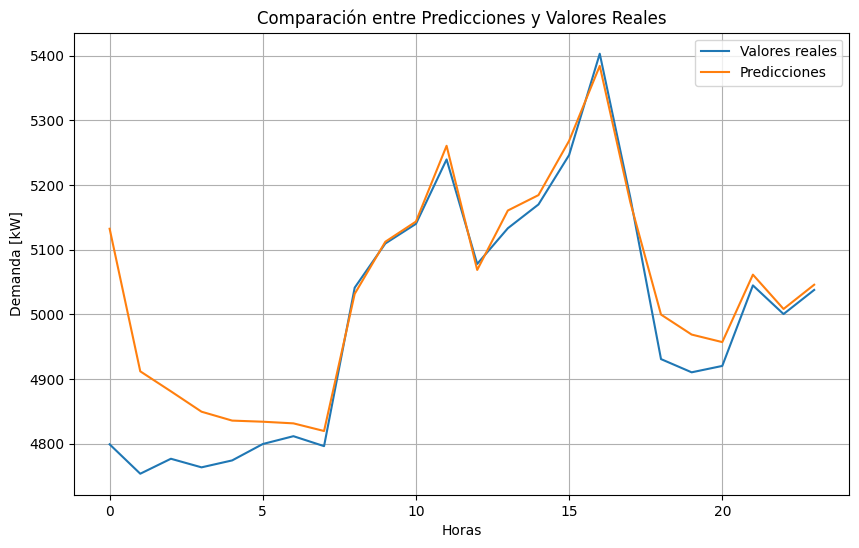

In [ ]:
# Crear una gráfica de comparación
plt.figure(figsize=(10, 6))
plt.plot(real_values, label='Valores reales')
plt.plot(next_predictions_denormalized, label='Predicciones')
plt.xlabel('Horas')
plt.ylabel('Demanda [kW]')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

real_values = np.array(real_values).flatten()
next_predictions_denormalized = np.array(next_predictions_denormalized).flatten()

# Crear el DataFrame
data = {'Horas': range(len(real_values)),
        'Valores reales': real_values,
        'Predicciones': next_predictions_denormalized}

df_AC_tabla = pd.DataFrame(data)

# Mostrar el DataFrame
print(df_AC_tabla.to_string(index=False))


 Horas  Valores reales  Predicciones
     0        4799.201   5132.575684
     1        4753.733   4912.068848
     2        4776.880   4881.171387
     3        4763.598   4849.643066
     4        4774.316   4835.878906
     5        4799.665   4834.155762
     6        4811.773   4831.613770
     7        4796.388   4819.791992
     8        5041.419   5031.831055
     9        5109.742   5112.470215
    10        5140.174   5143.696777
    11        5239.750   5260.857910
    12        5078.159   5068.874023
    13        5133.345   5160.772949
    14        5170.147   5184.597656
    15        5246.571   5268.565918
    16        5403.234   5384.432617
    17        5180.302   5173.121094
    18        4930.985   4999.826660
    19        4910.551   4968.932617
    20        4920.423   4957.266113
    21        5044.975   5061.569336
    22        5000.643   5008.520508
    23        5037.954   5045.996582


#Predicción demanda Gran consumidor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# Extraer la columna de demanda de energía
demand_data = dfGC['valor'].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
demand_data_normalized = scaler.fit_transform(demand_data.reshape(-1, 1))

# Dividir los datos en conjuntos de entrenamiento y prueba
validation_split = 0.2
train_size = int(len(demand_data_normalized) * (1 - validation_split))
train_data, test_data = demand_data_normalized[:train_size], demand_data_normalized[train_size:]

# Crear secuencias de entrada y salida para el entrenamiento de la red neuronal
sequence_length = 24
X_train, y_train = [], []
X_test, y_test = [], []
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data[i:i+sequence_length])
    y_train.append(train_data[i+sequence_length])
for i in range(len(test_data) - sequence_length):
    X_test.append(test_data[i:i+sequence_length])
    y_test.append(test_data[i+sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Crear el modelo de red neuronal
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='MSE', metrics=["mae","mse"])
model.summary()

# Entrenar el modelo
epochs = 20
batch_size = 16
patience = 3
early_stopping = EarlyStopping(patience=patience)  # Detener el entrenamiento si no hay mejora en el número de épocas especificado
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Desnormalizar los datos de predicción
y_pred_denormalized = scaler.inverse_transform(y_pred)
y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1348/1348 [==============================] - 36s 24ms/step - loss: 0.0132 - mae: 0.0515 - mse: 0.0132 - val_loss: 0.0013 - val_mae: 0.0268 - val_mse: 0.0013
Epoch 2/20
1348/1348 [==============================] - 32s 24ms/step - loss: 0.0016 - mae: 0.0269 - mse: 0.0016 - val_loss: 0.0010 - val_mae: 0.0234 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular el error absoluto medio (MAE) y el error cuadrático medio (MSE)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized)
r2 = r2_score(y_test_denormalized, y_pred_denormalized)

print('Error absoluto medio (MAE):', mae)
print('Error cuadrático medio (MSE):', mse)
print('Coeficiente de determinación (R^2):', r2)

Error absoluto medio (MAE): 56.065604765914046
Error cuadrático medio (MSE): 6009.67268748191
Coeficiente de determinación (R^2): 0.9160348884092357


In [ ]:
import pandas as pd
from datetime import datetime

# URL del archivo CSV
url = "https://raw.githubusercontent.com/crisalex25/TFM/main/GC3.csv"

# Leer el CSV y convertir la columna de fechas a datetime
df = pd.read_csv(url, sep=';', decimal=",", parse_dates=['Fecha_Hora'])

# Definir la fecha límite como el 11 de enero de 2023
fecha_limite = datetime(2023, 1, 12, 0, 0)

# Filtrar los datos para quedarse con los registros anteriores o iguales a la fecha límite
df_filtered = df[df['Fecha_Hora'] <= fecha_limite]

# Quedarse con los últimos 48 valores (si los datos están ordenados cronológicamente)
df_filtered_last_48 = df_filtered.tail(48)

# Mantener solamente los valores de la segunda columna (asumiendo que es la columna 1)
column_values = df_filtered_last_48.iloc[:, 1].to_numpy()

# Separar los valores en input_values (primeros 24) y real_values (últimos 24)
input_values = column_values[:24]
real_values = column_values[24:]

# Imprimir los valores de las columnas
print("Input Values:", input_values)
print("Real Values:", real_values)

Input Values: [1681.648 1718.754 1647.738 1630.375 1589.297 1626.531 1618.011 1677.401
 1579.263 1592.838 1606.405 1681.586 1746.807 1743.007 1747.208 1745.458
 1740.667 1753.235 1708.368 1693.312 1710.166 1723.219 1738.242 1737.144]
Real Values: [1736.243 1713.657 1738.263 1752.736 1740.607 1661.617 1667.081 1616.105
 1696.61  1710.487 1663.875 1678.089 1806.017 1819.875 1847.819 1895.153
 1867.717 1807.718 1785.045 1729.162 1657.415 1738.111 1722.31  1704.197]


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalizar los valores de entrada
scaler = MinMaxScaler(feature_range=(0, 1))
input_values_normalized = scaler.fit_transform(input_values.reshape(-1, 1))
real_values_normalized = scaler.fit_transform(real_values.reshape(-1, 1))

# valores de entrada
last_input_sequence = input_values_normalized

# Realizar predicciones para los próximos 24 valores
next_predictions = []
for i in range(24):
    # Preparar los últimos valores de entrada para la predicción
    next_input = last_input_sequence[-sequence_length:]  # Tomar el último valor real
    next_input = np.array(next_input).reshape(1, sequence_length, 1)

    # Realizar la predicción
    next_prediction = model.predict(next_input)

    # Agregar la predicción a la lista de predicciones
    next_predictions.append(next_prediction[0, 0])

    # Actualizar los últimos valores de entrada
    last_input_sequence = np.concatenate((last_input_sequence, real_values_normalized[i+1:i+2]), axis=0)

# Desnormalizar las predicciones
next_predictions_denormalized = scaler.inverse_transform(np.array(next_predictions).reshape(-1, 1))

print("Predicciones para los próximos 24 valores:")
print( next_predictions_denormalized)

1/1 [==============================] - 0s 33ms/step
Predicciones para los próximos 24 valores:
[[1863.6122]
 [1729.3188]
 [1762.5994]
 [1763.435 ]
 [1748.2252]
 [1665.3091]
 [1680.6832]
 [1613.5625]
 [1716.8268]
 [1709.1833]
 [1662.5836]
 [1687.7007]
 [1794.7864]
 [1807.4904]
 [1831.2087]
 [1850.6195]
 [1856.6443]
 [1816.1959]
 [1796.9899]
 [1741.7593]
 [1669.3158]
 [1757.8528]
 [1723.6152]
 [1710.5305]]


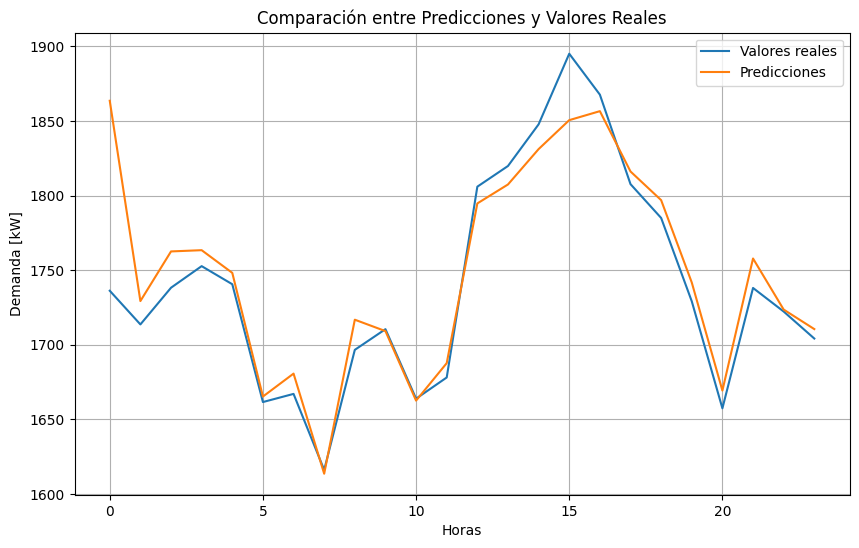

In [ ]:
# Crear una gráfica de comparación
plt.figure(figsize=(10, 6))
plt.plot(real_values, label='Valores reales')
plt.plot(next_predictions_denormalized, label='Predicciones')
plt.xlabel('Horas')
plt.ylabel('Demanda [kW]')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

real_values = np.array(real_values).flatten()
next_predictions_denormalized = np.array(next_predictions_denormalized).flatten()

# Crear el DataFrame
data = {'Horas': range(len(real_values)),
        'Valores reales': real_values,
        'Predicciones': next_predictions_denormalized}

df_GC_tabla = pd.DataFrame(data)

# Mostrar el DataFrame
print(df_GC_tabla.to_string(index=False))

 Horas  Valores reales  Predicciones
     0        1736.243   1863.612183
     1        1713.657   1729.318848
     2        1738.263   1762.599365
     3        1752.736   1763.435059
     4        1740.607   1748.225220
     5        1661.617   1665.309082
     6        1667.081   1680.683228
     7        1616.105   1613.562500
     8        1696.610   1716.826782
     9        1710.487   1709.183350
    10        1663.875   1662.583618
    11        1678.089   1687.700684
    12        1806.017   1794.786377
    13        1819.875   1807.490356
    14        1847.819   1831.208740
    15        1895.153   1850.619507
    16        1867.717   1856.644287
    17        1807.718   1816.195923
    18        1785.045   1796.989868
    19        1729.162   1741.759277
    20        1657.415   1669.315796
    21        1738.111   1757.852783
    22        1722.310   1723.615234
    23        1704.197   1710.530518


# Predicción de Precipitaciones

In [ ]:
PD="https://raw.githubusercontent.com/crisalex25/TFM/main/PrecD3.csv"

dfPD = pd.read_csv(PD, sep=';', decimal=",", parse_dates=['Fecha_Hora'])
fecha_limite = datetime(2023, 1, 1, 0, 0)  # Fecha límite
dfPD = dfPD[dfPD['Fecha_Hora'] <= fecha_limite]

In [ ]:
# Leer los datos del DataFrame
df = dfPD

# Obtener los valores de las precipitaciones diarias
precipitaciones = df.iloc[:, 1].values

# Normalizar los datos en el rango de 0 a 1
precipitaciones_min = np.min(precipitaciones)
precipitaciones_max = np.max(precipitaciones)
precipitaciones = (precipitaciones - precipitaciones_min) / (precipitaciones_max - precipitaciones_min)

# Crear las listas para almacenar los datos de entrada (X) y salida (y)
X = []
y = []

# Crear los datos de entrada y salida
sequence_length = 10  # Longitud de la secuencia de entrada para LSTM

for i in range(len(precipitaciones) - sequence_length):
    X.append(precipitaciones[i:i+sequence_length])
    y.append(precipitaciones[i+sequence_length])

X = np.array(X)
y = np.array(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

In [ ]:
import tensorflow as tf

# Crear el modelo de red neuronal LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo con un optimizador diferente y una tasa de aprendizaje diferente
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0009)  # Prueba con una tasa de aprendizaje más baja
model.compile(optimizer=optimizer, loss='mae')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,697
Trainable params: 37,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=730, verbose=1, validation_data=(X_test, y_test))

# Realizar predicciones
y_pred = model.predict(X_test)

# Asegurar que los valores de las predicciones no sean menores que cero
y_pred = np.maximum(y_pred, 0)

# Desnormalizar las predicciones y los datos reales
y_pred = (y_pred * (precipitaciones_max - precipitaciones_min)) + precipitaciones_min
y_test = (y_test * (precipitaciones_max - precipitaciones_min)) + precipitaciones_min

Epoch 1/100
4/4 [==============================] - 3s 144ms/step - loss: 0.0934 - val_loss: 0.0816
Epoch 2/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0878 - val_loss: 0.0764
Epoch 3/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0846 - val_loss: 0.0747
Epoch 4/100
4/4 [==============================] - 0s 56ms/step - loss: 0.0836 - val_loss: 0.0751
Epoch 5/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0824 - val_loss: 0.0756
Epoch 6/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0815 - val_loss: 0.0757
Epoch 7/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0816 - val_loss: 0.0753
Epoch 8/100
4/4 [==============================] - 0s 57ms/step - loss: 0.0810 - val_loss: 0.0744
Epoch 9/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0808 - val_loss: 0.0743
Epoch 10/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0807 - val_loss: 0.0738
Epoch 11/100
4/4 [

In [ ]:
import pandas as pd
from datetime import datetime

# URL del archivo CSV
url = "https://raw.githubusercontent.com/crisalex25/TFM/main/PrecD3.csv"

# Leer el CSV y convertir la columna de fechas a datetime
df = pd.read_csv(url, sep=';', decimal=",", parse_dates=['Fecha_Hora'])

# Definir la fecha límite como el 11 de enero de 2023
fecha_limite = datetime(2023, 1, 11)

# Filtrar los datos para quedarse con los registros anteriores o iguales a la fecha límite
df_filtered = df[df['Fecha_Hora'] <= fecha_limite]

# Quedarse con los últimos 11 valores (si los datos están ordenados cronológicamente)
df_filtered_last_11 = df_filtered.tail(11)

# Mantener solamente los valores de la segunda columna (asumiendo que es la columna 1)
column_values = df_filtered_last_11.iloc[:, 1].to_numpy()

# Separar los valores en input_values (primeros 10) y real_value (último valor)
input_values_prec = column_values[:-1]
real_value_prec = column_values[-1]

# Imprimir los valores de las columnas
print("Input Values:", input_values_prec)
print("Real Value:", real_value_prec)


Input Values: [ 3.8  4.9  0.3  2.4  3.5  1.2  0.7  0.   0.1 18.1]
Real Value: 23.8


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Calcular el mínimo y máximo de los valores de entrada
precipitaciones_min = np.min(input_values_prec)
precipitaciones_max = np.max(input_values_prec)

# Normalizar los datos de entrada
input_values_normalized = (input_values_prec - precipitaciones_min) / (precipitaciones_max - precipitaciones_min)

# Crear secuencias de entrada
sequence_length = 10
input_sequences = []

for i in range(len(input_values_normalized) - sequence_length + 1):
    input_sequences.append(input_values_normalized[i:i+sequence_length])

input_sequences = np.array(input_sequences)

# Realizar las predicciones
predictions_normalized = model.predict(input_sequences)

# Asegurar que los valores de las predicciones no sean menores que cero
predictions_normalized = np.maximum(predictions_normalized, 0)

# Desnormalizar las predicciones
predictions_denormalized = (predictions_normalized * (precipitaciones_max - precipitaciones_min)) + precipitaciones_min

# Imprimir las predicciones desnormalizadas
print("Prediccion:", predictions_denormalized)

1/1 [==============================] - 0s 22ms/step
Prediccion: [[10.687757]]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convertir los arrays en listas unidimensionales
real_value_prec = np.array(real_value_prec).flatten()
predictions_denormalized = np.array(predictions_denormalized).flatten()

# Crear el DataFrame
data = {'Valor real': real_value_prec,
        'Prediccion': predictions_denormalized}

df_prec_tabla = pd.DataFrame(data)

# Mostrar el DataFrame
print(df_prec_tabla)



   Valor real  Prediccion
0        23.8   10.687757


#Optimización

##Cálculo de caudales Disponible

In [ ]:

def caudal_disponible_pap(x):
    return round(0.0014 * x ** 2 + 0.0512 * x + 2.112, 2)

def caudal_disponible_lor(x):
    return round(0.0007 * x ** 2 - 0.009 * x + 0.8754, 2)

##Algoritmo Genético Central Loreto


In [ ]:
import random
from tabulate import tabulate

## Definición de funciones

# Función para calcular los caudales turbinados y disponibles
def calcular_caudal_turbinado(potencia_unit):
    caudal_turbinado = max(0.0005 * potencia_unit - 0.0154, 0.0)
    return round(caudal_turbinado, 2)

# Función para calcular el costo del déficit de generación
def calcular_costo_deficit(generacion, demanda, costo_horario):
    deficit = generacion - demanda
    if deficit < 0:
        costo_deficit = abs(deficit) * costo_horario / 100
    else:
        costo_deficit = 0

    return round(costo_deficit, 2)

# Función para generar una solución inicial de generación
def generar_solucion_inicial(capacidad_unit, rango_horario):
    generacion_inicial = []
    for hora in rango_horario:
        # Generar una potencia aleatoria entre 500 y la capacidad máxima
        potencia_unit = max(random.uniform(0, capacidad_unit), 500)

        caudal_turbinado = calcular_caudal_turbinado(potencia_unit)

        while caudal_turbinado > caudal_disponible:
            potencia_unit = max(random.uniform(0, capacidad_unit), 500)
            caudal_turbinado = calcular_caudal_turbinado(potencia_unit)

        generacion_inicial.append(potencia_unit)

    return generacion_inicial

def generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion):
    poblacion = []
    for _ in range(tam_poblacion):
        individuo = generar_solucion_inicial(capacidad_unit, rango_horario)
        poblacion.append(individuo)
    return poblacion

# Función para realizar el crossover entre dos individuos
def crossover(padre1, padre2):
    punto_corte = random.choice(range(len(padre1)))
    hijo2 = padre2[:punto_corte] + padre1[punto_corte:]
    return hijo2

# Función para aplicar mutación a un individuo
def mutacion(individuo, prob_mutacion, capacidad_unit):
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:
            nueva_potencia_unit = max(random.uniform(0, capacidad_unit), 500)

            caudal_turbinado = calcular_caudal_turbinado(nueva_potencia_unit)

            while caudal_turbinado > caudal_disponible:
                nueva_potencia_unit = max(random.uniform(0, capacidad_unit), 500)
                caudal_turbinado = calcular_caudal_turbinado(nueva_potencia_unit)

            individuo[i] = nueva_potencia_unit
    return individuo

# Función principal para aplicar el algoritmo genético
def aplicar_algoritmo_genetico(capacidad_unit, demanda_energia, costo_horario, rango_horario,
                               tam_poblacion, prob_crossover, prob_mutacion, num_generaciones):

    poblacion = generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion)

    for _ in range(num_generaciones):
        costos = []

        for generacion in poblacion:
            costo_generacion = sum(
                calcular_costo_deficit(
                    generacion[i], demanda_energia[i], costo_horario[i]
                )
                for i in range(len(rango_horario))
            )
            costos.append(costo_generacion)

        idx_mejor = min(range(len(costos)), key=lambda k: costos[k])
        padre = poblacion[idx_mejor]

        hijo = crossover(padre, padre)

        hijo_mutado = mutacion(hijo, prob_mutacion, capacidad_unit)

        idx_peor = max(range(len(costos)), key=lambda k: costos[k])
        poblacion[idx_peor] = hijo_mutado

    mejor_idx = min(range(len(costos)), key=lambda k: costos[k])
    mejor_generacion = poblacion[mejor_idx]
    mejor_costo_deficit = costos[mejor_idx]

    return mejor_generacion, mejor_costo_deficit

In [ ]:
# Definición de variables y parámetros

caudal_disponible = caudal_disponible_lor(10.687757)
rango_horario = range(24)
capacidad_unit = 2150
costo_horario = [10.0758, 10.0758, 10.0758, 10.0758, 10.0758,
                10.0758, 10.0758, 10.2747, 10.2747, 10.0758,
                10.0758, 8.9923, 8.9923, 8.9923, 8.9923,
                8.9923, 9.4635, 8.6318, 9.4635, 9.4635,
                9.4635, 9.4635, 8.9923, 9.8743]

demanda_gc = np.round(df_GC_tabla["Predicciones"].to_numpy()).astype(int)
print(demanda_gc)
print(caudal_disponible)
tam_poblacion = 2000
prob_crossover = 0.8
prob_mutacion = 0.2
num_generaciones = 2000

# Aplicar el algoritmo genético
mejor_generacion, mejor_costo_deficit = aplicar_algoritmo_genetico(
    capacidad_unit,
    demanda_gc,
    costo_horario,
    rango_horario,
    tam_poblacion,
    prob_crossover,
    prob_mutacion,
    num_generaciones,
)

[1864 1729 1763 1763 1748 1665 1681 1614 1717 1709 1663 1688 1795 1807
 1831 1851 1857 1816 1797 1742 1669 1758 1724 1711]
0.84


In [ ]:
# Crear tabla de resultados
tabla_resultados = []
for hora, generacion in enumerate(mejor_generacion):
    caudal_turbinado = calcular_caudal_turbinado(generacion)
    costo_deficit = calcular_costo_deficit(
        generacion, demanda_gc[hora], costo_horario[hora]
    )
    fila = [
        hora,
        demanda_gc[hora],
        generacion,
        caudal_turbinado,
        caudal_disponible,
        costo_deficit,
        costo_horario[hora]
    ]
    tabla_resultados.append(fila)

# Mostrar tabla de resultados
headers = ["Hora", "Demanda", "Generación U3", "Caudal Turb", "Caudal Disp", "Costo Total Défic", "Precio kwh ctvs"]
tabla = tabulate(tabla_resultados, headers, tablefmt="grid")
print(tabla)

# Calcular el costo total del déficit acumulado
costo_total_deficit = sum(row[5] for row in tabla_resultados)

# Mostrar el costo total del déficit acumulado
print("\nCosto total del déficit acumulado: ${:.2f}".format(costo_total_deficit))

+--------+-----------+-----------------+---------------+---------------+---------------------+-------------------+
|   Hora |   Demanda |   Generación U3 |   Caudal Turb |   Caudal Disp |   Costo Total Défic |   Precio kwh ctvs |
+========+===========+=================+===============+===============+=====================+===================+
|      0 |      1864 |         1464.49 |          0.72 |          0.84 |               40.25 |           10.0758 |
+--------+-----------+-----------------+---------------+---------------+---------------------+-------------------+
|      1 |      1729 |         1629.07 |          0.8  |          0.84 |               10.07 |           10.0758 |
+--------+-----------+-----------------+---------------+---------------+---------------------+-------------------+
|      2 |      1763 |         1558.59 |          0.76 |          0.84 |               20.6  |           10.0758 |
+--------+-----------+-----------------+---------------+---------------+--------

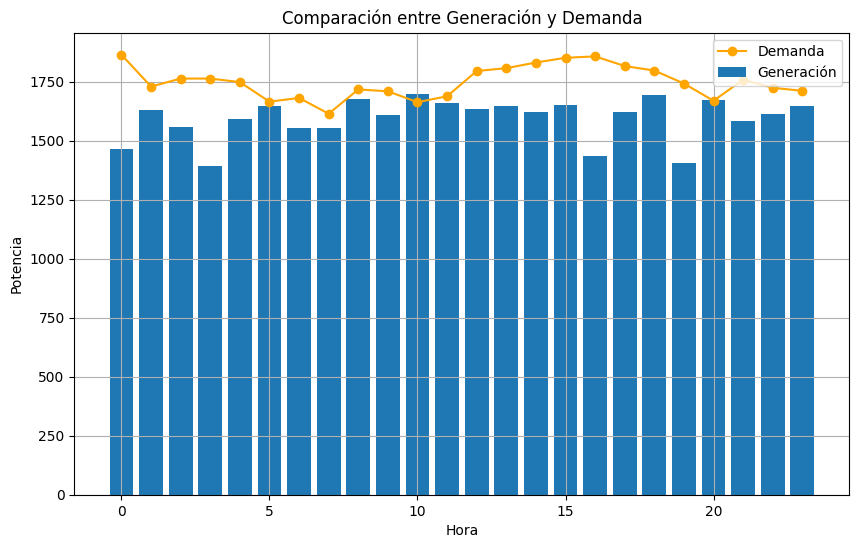

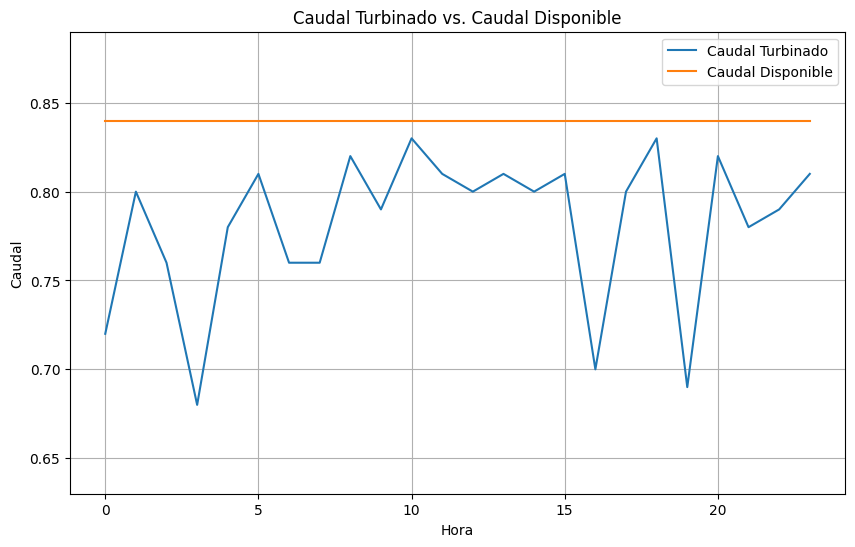

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Función para graficar la comparación entre generación y demanda en forma de barras
def graficar_generacion_vs_demanda(rango_horario, generacion, demanda):
    plt.figure(figsize=(10, 6))
    plt.bar(rango_horario, generacion, label='Generación')
    plt.plot(rango_horario, demanda, label='Demanda', marker='o', color='orange')
    plt.xlabel('Hora')
    plt.ylabel('Potencia')
    plt.title('Comparación entre Generación y Demanda')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)  # Ajustar el límite inferior del eje Y a 0
    plt.show()

# Función para graficar el caudal turbado y caudal disponible centrados
def graficar_caudales(rango_horario, caudal_turbinado, caudal_disponible):
    plt.figure(figsize=(10, 6))
    plt.plot(rango_horario, caudal_turbinado, label='Caudal Turbinado')
    plt.plot(rango_horario, caudal_disponible, label='Caudal Disponible')
    plt.xlabel('Hora')
    plt.ylabel('Caudal')
    plt.title('Caudal Turbinado vs. Caudal Disponible')
    plt.legend()
    plt.grid(True)

    # Encontrar el valor máximo entre los caudales para centrar la gráfica
    max_caudal = max(max(caudal_turbinado), max(caudal_disponible)) + 0.05
    min_caudal = min(min(caudal_turbinado), min(caudal_disponible)) - 0.05
    plt.ylim(min_caudal, max_caudal)  # Ajustar los límites del eje Y
    plt.show()

# Obtener los valores de caudal turbinado y caudal disponible
caudales_turbinados = [calcular_caudal_turbinado(generacion) for generacion in mejor_generacion]
caudales_disponibles = [caudal_disponible] * len(rango_horario)  # Replicar el valor para cada hora

# Convertir el rango horario en una lista para usarlo como coordenadas en la gráfica de barras
rango_horario_lista = list(rango_horario)

# Graficar la comparación entre generación y demanda en forma de barras
graficar_generacion_vs_demanda(rango_horario_lista, mejor_generacion, demanda_gc)

# Graficar el caudal turbado y caudal disponible centrados
graficar_caudales(rango_horario_lista, caudales_turbinados, caudales_disponibles)


##Algoritmo Genético Central Papallacta


In [ ]:
import random
from tabulate import tabulate

# Restricciones de los generadores
generador_1_range = (400, 1850)
generador_2_range = (1600, 4200)

# Función para calcular los caudales turbinados y disponibles
def calcular_caudal_turbinado(generator_number, potencia_unit):
    if generator_number == 1:
        return round(max(0.001118 * potencia_unit - 0.0007556, 0), 2)
    else:
        return round(0.000835 * potencia_unit + 0.001027, 2)

# Función para calcular el costo del déficit de generación
def calcular_costo_deficit(generacion, demanda, costo_horario):
    deficit = generacion - demanda
    if deficit < 0:
        costo_deficit = abs(deficit) * costo_horario / 100
    else:
        costo_deficit = 0

    return round(costo_deficit, 2)

# Función para generar una solución inicial de generación
def generar_solucion_inicial(capacidad_unit, rango_horario, demanda_energia):
    generacion_inicial = []
    for hora in rango_horario:
        demanda = demanda_energia[hora]
        max_generador_2 = min(capacidad_unit - generador_1_range[0], generador_2_range[1])
        potencia_unit_2 = random.uniform(generador_2_range[0], max_generador_2)

        if potencia_unit_2 > 4190 and (demanda - potencia_unit_2) > generador_1_range[0]:
            potencia_unit_1 = demanda - potencia_unit_2
        else:
            potencia_unit_1 = 0

        while (calcular_caudal_turbinado(1, potencia_unit_1) + calcular_caudal_turbinado(2, potencia_unit_2)) >= caudal_disponible:
            potencia_unit_2 = random.uniform(generador_2_range[0], max_generador_2)
            if potencia_unit_2 > 4190 and (demanda - potencia_unit_2) > generador_1_range[0]:
                potencia_unit_1 = demanda - potencia_unit_2
            else:
                potencia_unit_1 = 0

        generacion_inicial.append((potencia_unit_1, potencia_unit_2))

    return generacion_inicial

# ... (resto del código)

# ... (código anterior)

def generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion, demanda_energia):
    poblacion = []
    for _ in range(tam_poblacion):
        individuo = generar_solucion_inicial(capacidad_unit, rango_horario, demanda_energia)
        poblacion.append(individuo)
    return poblacion

def crossover(padre1, padre2):
    punto_corte = random.choice(range(len(padre1)))
    hijo2 = padre2[:punto_corte] + padre1[punto_corte:]
    return hijo2

def mutacion(individuo, prob_mutacion, capacidad_unit):
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:
            potencia_unit_1, potencia_unit_2 = individuo[i]
            demanda = demanda_gc[i]

            nueva_potencia_unit_2 = random.uniform(generador_2_range[0], generador_2_range[1])

            if nueva_potencia_unit_2 > 4190 and (demanda - nueva_potencia_unit_2) > generador_1_range[0]:
                nueva_potencia_unit_1 = demanda - nueva_potencia_unit_2
            else:
                nueva_potencia_unit_1 = 0

            while (calcular_caudal_turbinado(1, nueva_potencia_unit_1) + calcular_caudal_turbinado(2, nueva_potencia_unit_2)) >= caudal_disponible:
                nueva_potencia_unit_2 = random.uniform(generador_2_range[0], generador_2_range[1])
                if nueva_potencia_unit_2 > 4190 and (demanda - nueva_potencia_unit_2) > generador_1_range[0]:
                    nueva_potencia_unit_1 = demanda - nueva_potencia_unit_2
                else:
                    nueva_potencia_unit_1 = 0

            individuo[i] = (nueva_potencia_unit_1, nueva_potencia_unit_2)
    return individuo


def aplicar_algoritmo_genetico(capacidad_unit, demanda_energia, costo_horario, rango_horario, tam_poblacion, prob_crossover, prob_mutacion, num_generaciones):
    poblacion = generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion, demanda_energia)

    for _ in range(num_generaciones):
        costos = []

        for generacion in poblacion:
            costo_generacion = sum(
                calcular_costo_deficit(
                    generacion[i][0] + generacion[i][1], demanda_energia[i], costo_horario[i]
                )
                for i in range(len(rango_horario))
            )
            costos.append(costo_generacion)

        idx_mejor = min(range(len(costos)), key=lambda k: costos[k])
        padre = poblacion[idx_mejor]

        hijo = crossover(padre, padre)

        hijo_mutado = mutacion(hijo, prob_mutacion, capacidad_unit)

        idx_peor = max(range(len(costos)), key=lambda k: costos[k])
        poblacion[idx_peor] = hijo_mutado

    mejor_idx = min(range(len(costos)), key=lambda k: costos[k])
    mejor_generacion = poblacion[mejor_idx]
    mejor_costo_deficit = costos[mejor_idx]

    return mejor_generacion, mejor_costo_deficit


In [ ]:

# Definición de variables y parámetros
caudal_disponible = caudal_disponible_pap(10.687757)
rango_horario = range(24)
costo_horario = [10.0758, 10.0758, 10.0758, 10.0758, 10.0758,
                10.0758, 10.0758, 10.2747, 10.2747, 10.0758,
                10.0758, 8.9923, 8.9923, 8.9923, 8.9923,
                8.9923, 9.4635, 8.6318, 9.4635, 9.4635,
                9.4635, 9.4635, 8.9923, 9.8743]

demanda_gc = np.round(df_AC_tabla["Predicciones"].to_numpy()).astype(int)

tam_poblacion = 2000
prob_crossover = 0.8
prob_mutacion = 0.2
num_generaciones = 2000

# Aplicar el algoritmo genético
mejor_generacion, mejor_costo_deficit = aplicar_algoritmo_genetico(
    capacidad_unit,
    demanda_gc,
    costo_horario,
    rango_horario,
    tam_poblacion,
    prob_crossover,
    prob_mutacion,
    num_generaciones,
)

In [ ]:
# Crear tabla de resultados
tabla_resultados = []
for hora, (generacion_1, generacion_2) in enumerate(mejor_generacion):
    caudal_turbinado_1 = calcular_caudal_turbinado(1, generacion_1)
    caudal_turbinado_2 = calcular_caudal_turbinado(2, generacion_2)
    caudal_total_turbinado = caudal_turbinado_1 + caudal_turbinado_2

    costo_deficit = calcular_costo_deficit(
        generacion_1 + generacion_2, demanda_gc[hora], costo_horario[hora]
    )

    fila = [
        hora,
        demanda_gc[hora],
        generacion_1,
        generacion_2,
        caudal_turbinado_1,
        caudal_turbinado_2,
        caudal_total_turbinado,
        caudal_disponible,
        costo_deficit,
        costo_horario[hora]
    ]
    tabla_resultados.append(fila)

# Mostrar tabla de resultados
headers = ["Hora", "Demanda", "Generación G1", "Generación G2", "Caudal Turb G1", "Caudal Turb G2", "Caudal Turb Total", "Caudal Disp", "Costo Total Défic", "Precio kwh ctvs"]
tabla = tabulate(tabla_resultados, headers, tablefmt="grid")
print(tabla)

# Calcular el costo total del déficit acumulado
costo_total_deficit = sum(row[8] for row in tabla_resultados)

# Mostrar el costo total del déficit acumulado
print("\nCosto total del déficit acumulado: ${:.2f}".format(costo_total_deficit))


+--------+-----------+-----------------+-----------------+------------------+------------------+---------------------+---------------+---------------------+-------------------+
|   Hora |   Demanda |   Generación G1 |   Generación G2 |   Caudal Turb G1 |   Caudal Turb G2 |   Caudal Turb Total |   Caudal Disp |   Costo Total Défic |   Precio kwh ctvs |
+========+===========+=================+=================+==================+==================+=====================+===============+=====================+===================+
|      0 |      5133 |               0 |         2917.91 |                0 |             2.44 |                2.44 |          2.82 |              223.19 |           10.0758 |
+--------+-----------+-----------------+-----------------+------------------+------------------+---------------------+---------------+---------------------+-------------------+
|      1 |      4912 |               0 |         3173.36 |                0 |             2.65 |                2.6

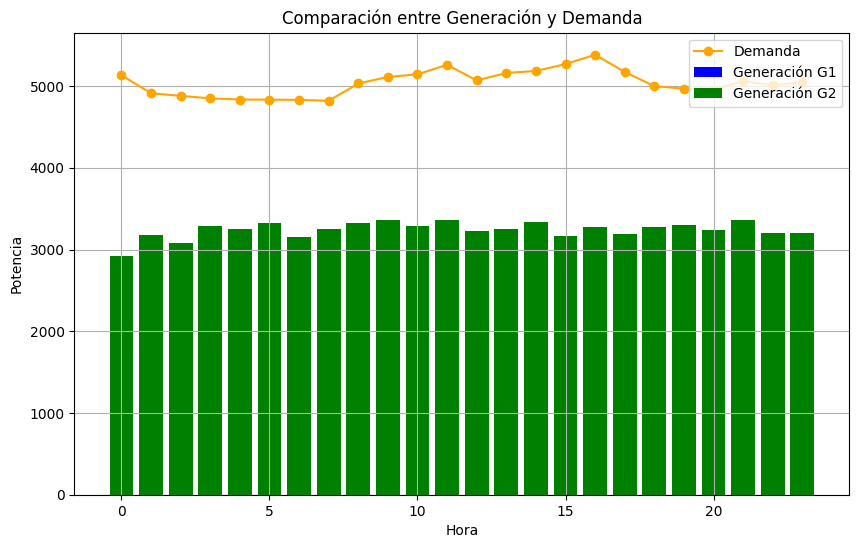

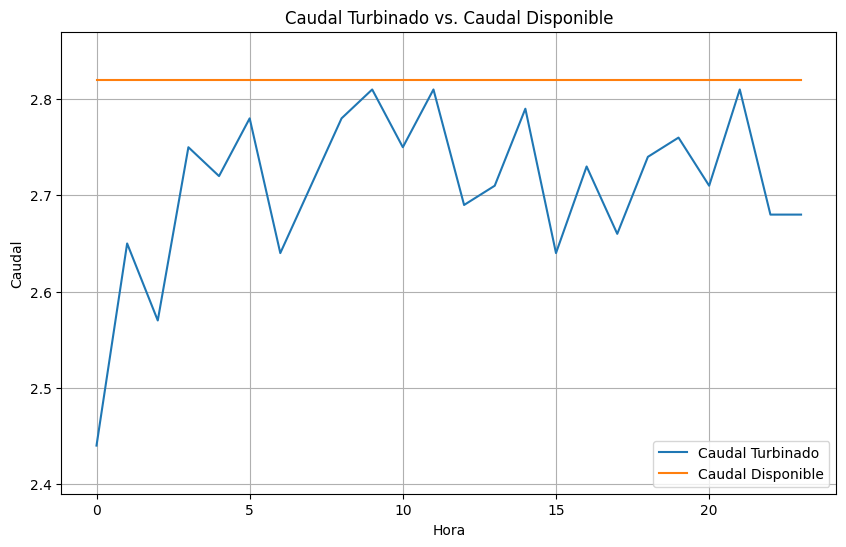

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate  # Asegúrate de tener la librería tabulate instalada

def graficar_generacion_vs_demanda(rango_horario, generacion_g1, generacion_g2, demanda):
    plt.figure(figsize=(10, 6))
    plt.bar(rango_horario, generacion_g1, label='Generación G1', color='blue')
    plt.bar(rango_horario, generacion_g2, bottom=generacion_g1, label='Generación G2', color='green')
    plt.plot(rango_horario, demanda, label='Demanda', marker='o', color='orange')
    plt.xlabel('Hora')
    plt.ylabel('Potencia')
    plt.title('Comparación entre Generación y Demanda')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)
    plt.show()

# Función para graficar el caudal turbado y caudal disponible centrados
def graficar_caudales(rango_horario, caudal_turbinado, caudal_disponible):
    plt.figure(figsize=(10, 6))
    plt.plot(rango_horario, caudal_turbinado, label='Caudal Turbinado')
    plt.plot(rango_horario, caudal_disponible, label='Caudal Disponible')
    plt.xlabel('Hora')
    plt.ylabel('Caudal')
    plt.title('Caudal Turbinado vs. Caudal Disponible')
    plt.legend()
    plt.grid(True)

    # Encontrar el valor máximo entre los caudales para centrar la gráfica
    max_caudal = max(max(caudal_turbinado), max(caudal_disponible)) + 0.05
    min_caudal = min(min(caudal_turbinado), min(caudal_disponible)) - 0.05
    plt.ylim(min_caudal, max_caudal)  # Ajustar los límites del eje Y
    plt.show()

# Obtener los valores de caudal turbinado y caudal disponible
caudales_turbinados = [calcular_caudal_turbinado(1, generacion_1) + calcular_caudal_turbinado(2, generacion_2) for generacion_1, generacion_2 in mejor_generacion]
caudales_disponibles = [caudal_disponible] * len(rango_horario)  # Replicar el valor para cada hora

# Convertir el rango horario en una lista para usarlo como coordenadas en la gráfica de barras
rango_horario_lista = list(rango_horario)

# Obtener los valores de generación de las turbinas G1 y G2
generacion_g1 = [generacion_1 for generacion_1, _ in mejor_generacion]
generacion_g2 = [generacion_2 for _, generacion_2 in mejor_generacion]

# Graficar la comparación entre generación y demanda en forma de barras
graficar_generacion_vs_demanda(rango_horario_lista, generacion_g1, generacion_g2, demanda_gc)

# Graficar el caudal turbado y caudal disponible centrados
graficar_caudales(rango_horario_lista, caudales_turbinados, caudales_disponibles)
